In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math
from sklearn.model_selection import train_test_split
import schedulefree
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
#from torchinfo import summary
import torch.optim as optim
from functools import partial
assert torch.cuda.is_available()

# Not always necessary depending on your hardware/GPU
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [12]:
input_width = 512
input_height = 512
MODEL_SCALE = 4
workers = 8
batch_size = 8

Image image_1109.png
Image shape = (512, 512, 3)
            name  img_width  img_height      x      y      w      l     angle  \
1178  image_1109        512         512  277.0  256.0  46.27  62.21 -0.705712   

          h  
1178  62.21  


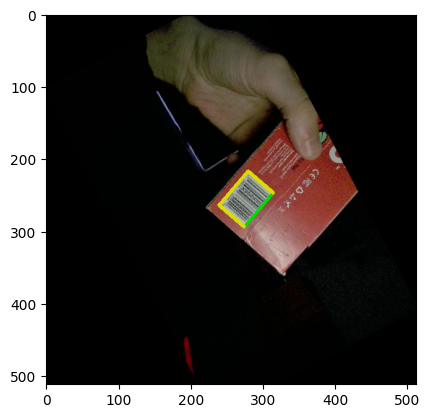

In [3]:
dataset_folder = 'images_augmented/'
labels_file = "train.csv"

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder, IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Load labels
train_df = pd.read_csv(labels_file)
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['l'].astype(float)
train_df['angle'] = train_df['angle'].astype(float)

print(f"Image shape = {img.shape}")

target = train_df[train_df['name']==IMAGE[:-4]]
print(target)

# convert targets to its center.
centers = np.array([target["x"], target["y"]]).T

rotations = []
for angle in target["angle"]:
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotations.append(np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]]))

bboxs = target[["x", "y", "w", "l"]].to_numpy()

for center, rot, box in zip(centers, rotations, bboxs):
    bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    
    br = (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1]))
    tr = (int(center[0]+top_right[0]), int(center[1]+top_right[1]))
    tl = (int(center[0]+top_left[0]), int(center[1]+top_left[1]))
    bl = (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1]))

    thickness = 3
    cv2.line(img, br, tr, (0, 220, 0), thickness)
    cv2.line(img, br, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, tr, (220, 220, 0), thickness)

#plt.figure(figsize=(14,14))
plt.imshow(img)

In [3]:
def draw_msra_gaussian(heatmap, center, sigma=6):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap




def draw_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 + sq1) / 2

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 + sq2) / 2

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2
    return min(r1, r2, r3)

In [4]:

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset
    
def make_hm_offset_regr_angle(target):
    hm = np.zeros([2,input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    regr = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    cos_sin_hm = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    mask  = np.zeros((input_height//MODEL_SCALE, input_width//MODEL_SCALE), dtype=np.float32)
    if len(target) == 0:
        return hm, offset, regr, cos_sin_hm
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    for i, c in target.iterrows():
        w,h = c["w"],c["l"]
        
        #4 points
        angle = c["angle"]
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        box = c[["x", "y", "w", "l"]].to_numpy()
        center = np.array([c["x"], c["y"]]).T
        bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        br = (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])) 
        tr = (int(center[0]+top_right[0]), int(center[1]+top_right[1]))
        tl = (int(center[0]+top_left[0]), int(center[1]+top_left[1]))
        bl = (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1]))
        
        br = int(br[0]/MODEL_SCALE),int(br[1]/MODEL_SCALE)
        tr = int(tr[0]/MODEL_SCALE),int(tr[1]/MODEL_SCALE)
        tl = int(tl[0]/MODEL_SCALE),int(tl[1]/MODEL_SCALE)
        bl = int(bl[0]/MODEL_SCALE),int(bl[1]/MODEL_SCALE)
        #
        
        radius = gaussian_radius((math.ceil(h), math.ceil(w)))
        radius = max(0, int(radius))
        #hm = draw_msra_gaussian(hm, [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
        #                        sigma=6)
        ct_int = (int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE))
        hm[0] = draw_gaussian(hm[0], ct_int, 4)
        hm[1] = draw_gaussian(hm[1], br, 4)
        hm[1] = draw_gaussian(hm[1], tr, 4)
        hm[1] = draw_gaussian(hm[1], tl, 4)
        hm[1] = draw_gaussian(hm[1], bl, 4)
        assert 0 <= c["x"] < 1280
        assert 0 <= c["y"] < 720
        offset = draw_offset(offset, c["x"]/MODEL_SCALE, c["y"]/MODEL_SCALE)
        regr[0, int(c["y"]/MODEL_SCALE), int(c["x"]/MODEL_SCALE)] = c["w"]/MODEL_SCALE
        regr[1, int(c["y"]/MODEL_SCALE), int(c["x"]/MODEL_SCALE)] = c["l"]/MODEL_SCALE
        cos_sin_hm[0, int(c["y"]/MODEL_SCALE), int(c["x"]/MODEL_SCALE)] = np.cos(c["angle"])
        cos_sin_hm[1, int(c["y"]/MODEL_SCALE), int(c["x"]/MODEL_SCALE)] = np.sin(c["angle"])
        mask[ct_int[1], ct_int[0]] = 1
        # for i in range(-1, 2):
        #     for j in range(-1, 2):
        #         try:
        #             regr[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["w"]/MODEL_SCALE
        #             regr[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["l"]/MODEL_SCALE
        #             cos_sin_hm[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.cos(c["angle"])
        #             cos_sin_hm[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.sin(c["angle"])
        #         except:
        #             pass
        #angles= target["angle"]
        
                
    #regr[0] = regr[0].T; regr[1] = regr[1].T;
    #angle = angle.T
    return hm, offset, regr, cos_sin_hm,mask


In [2]:
def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm

In [21]:
def pred2box(hm, offset, regr, cos_sin_hm, thresh=0.99):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b, pred_angle) in zip(pred_center, pred_r, pred_angles):
        #print(b)
        print("Center is:",center)
        offset_xy = offset[:, center[0], center[1]]
        print("Offset is:",offset_xy)
        angle = np.arctan2(pred_angle[1], pred_angle[0])
        print("Angle is:",angle)
        print("b is:",b)
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE, angle])
        print("Arr is:",arr)
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores

In [4]:
# functions for plotting results
def showbox(img, hm, offset, regr, cos_sin_hm, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, cos_sin_hm, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])]
        cos_angle = np.cos(box[4])
        sin_angle = np.sin(box[4])
        rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        
        bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        thickness = 3
        cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
                      (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
                      (0, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
                      (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
                      (220, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
                      (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
                      (220, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
                      (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
                      (220, 220, 0), thickness)
    return sample


In [5]:
def load_model(model, model_path, optimizer=None, resume=False, 
               lr=None, lr_step=None):
  start_epoch = 0
  checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
  print('loaded {}, epoch {}'.format(model_path, checkpoint['epoch']))
  state_dict_ = checkpoint['state_dict']
  state_dict = {}
  
  # convert data_parallal to model
  for k in state_dict_:
    if k.startswith('module') and not k.startswith('module_list'):
      state_dict[k[7:]] = state_dict_[k]
    else:
      state_dict[k] = state_dict_[k]
  model_state_dict = model.state_dict()

  # check loaded parameters and created model parameters
  msg = 'If you see this, your model does not fully load the ' + \
        'pre-trained weight. Please make sure ' + \
        'you have correctly specified --arch xxx ' + \
        'or set the correct --num_classes for your own dataset.'
  for k in state_dict:
    if k in model_state_dict:
      if state_dict[k].shape != model_state_dict[k].shape:
        print('Skip loading parameter {}, required shape{}, '\
              'loaded shape{}. {}'.format(
          k, model_state_dict[k].shape, state_dict[k].shape, msg))
        state_dict[k] = model_state_dict[k]
    else:
      print('Drop parameter {}.'.format(k) + msg)
  for k in model_state_dict:
    if not (k in state_dict):
      print('No param {}.'.format(k) + msg)
      state_dict[k] = model_state_dict[k]
  model.load_state_dict(state_dict, strict=False)

  # resume optimizer parameters
  if optimizer is not None and resume:
    if 'optimizer' in checkpoint:
      optimizer.load_state_dict(checkpoint['optimizer'])
      start_epoch = checkpoint['epoch']
      start_lr = lr
      for step in lr_step:
        if start_epoch >= step:
          start_lr *= 0.1
      for param_group in optimizer.param_groups:
        param_group['lr'] = start_lr
      print('Resumed optimizer with start lr', start_lr)
    else:
      print('No optimizer parameters in checkpoint.')
  if optimizer is not None:
    return model, optimizer, start_epoch
  else:
    return model

In [10]:
# Split train-test by unique image ids, corresponding to image paths
train_id, test_id = train_test_split(sorted(os.listdir(dataset_folder)), test_size=0.1, random_state=777)

In [6]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(dataset_folder, self.img_id[idx]))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['name']==self.img_id[idx][:-4]]
        hm, offset, regr, cos_sin_hm,mask = make_hm_offset_regr_angle(target)
        #assert(hm.shape == (128, 128))
        #assert(regr.shape == (2, 128, 128))
        #assert(angle.shape == (128, 128))
        return img, hm, offset, regr, cos_sin_hm,mask


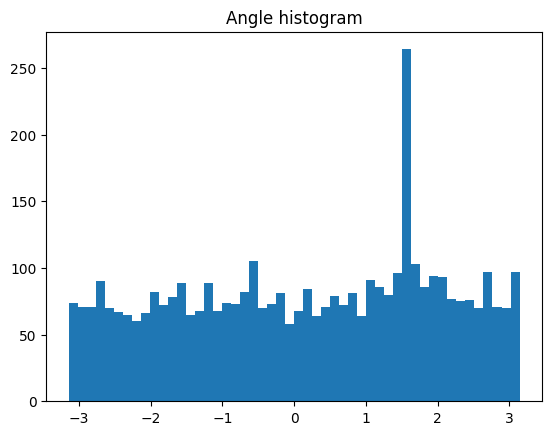

In [12]:
traindataset = CarDataset(train_id, train_df)
valdataset = CarDataset(test_id, train_df)

# Your angle histogram should be as flat as possible to reduce overfitting!
target = train_df["angle"]
plt.hist(target, bins=50)
plt.title("Angle histogram")
plt.show()


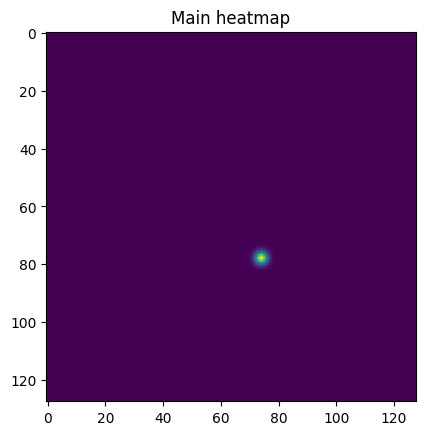

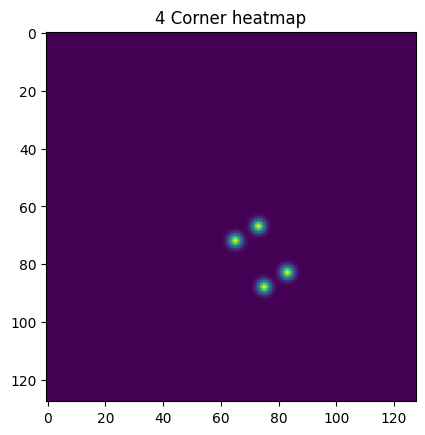

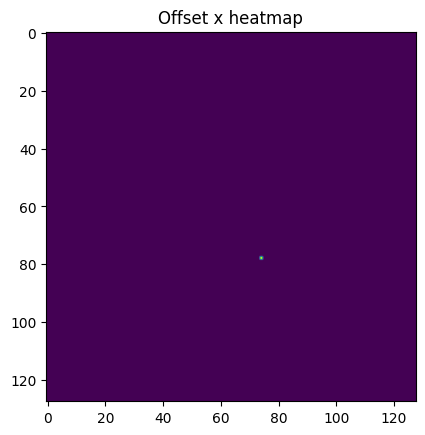

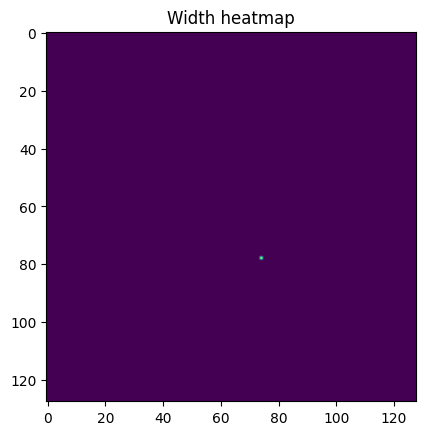

(2, 128, 128)


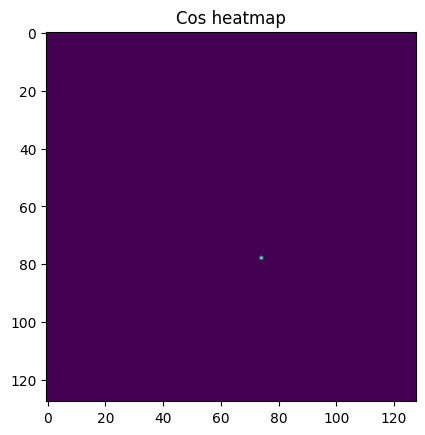

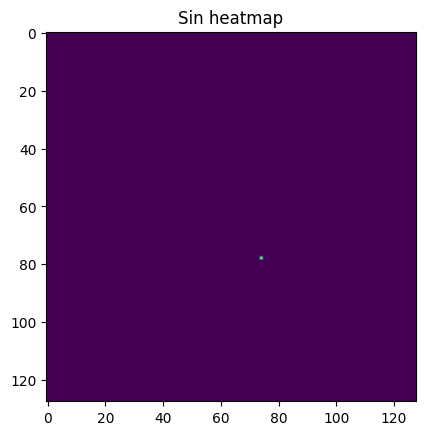

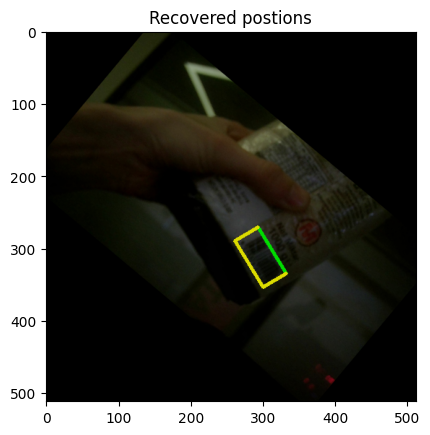

In [13]:
# Check traindataset

k = random.randint(0, len(train_id))
# Test dataset
img, hm, offset, regr, cos_sin_hm,mask = traindataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm[1])
plt.title("4 Corner heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

print(cos_sin_hm.shape)

plt.imshow(cos_sin_hm[0])
plt.title("Cos heatmap")
plt.show()

plt.imshow(cos_sin_hm[1])
plt.title("Sin heatmap")
plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(os.path.join(dataset_folder, train_id[k]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = showbox(img, hm[0], offset, regr, cos_sin_hm, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [14]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True,num_workers=workers)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=False,num_workers=workers)

In [8]:
from hardnet import get_pose_net
model = get_pose_net(85,{"hm":2,"offset":2,"wh":2,"angle":2})
model = load_model(model,"centernet_hardnet85_coco.pth")

3 x 3 x 3 x 48
3 x 3 x 48 x 96
3 x 3 x 96 x 24
3 x 3 x 120 x 40
3 x 3 x 40 x 24
3 x 3 x 160 x 70
3 x 3 x 70 x 24
3 x 3 x 94 x 40
3 x 3 x 40 x 24
3 x 3 x 230 x 118
Blk out = 214
1 x 1 x 214 x 192
3 x 3 x 192 x 24
3 x 3 x 216 x 40
3 x 3 x 40 x 24
3 x 3 x 256 x 70
3 x 3 x 70 x 24
3 x 3 x 94 x 40
3 x 3 x 40 x 24
3 x 3 x 326 x 118
3 x 3 x 118 x 24
3 x 3 x 142 x 40
3 x 3 x 40 x 24
3 x 3 x 182 x 70
3 x 3 x 70 x 24
3 x 3 x 94 x 40
3 x 3 x 40 x 24
3 x 3 x 444 x 200
Blk out = 392
1 x 1 x 392 x 256
3 x 3 x 256 x 28
3 x 3 x 284 x 48
3 x 3 x 48 x 28
3 x 3 x 332 x 80
3 x 3 x 80 x 28
3 x 3 x 108 x 48
3 x 3 x 48 x 28
3 x 3 x 412 x 138
3 x 3 x 138 x 28
3 x 3 x 166 x 48
3 x 3 x 48 x 28
3 x 3 x 214 x 80
3 x 3 x 80 x 28
3 x 3 x 108 x 48
3 x 3 x 48 x 28
3 x 3 x 550 x 234
Blk out = 458
1 x 1 x 458 x 320
3 x 3 x 320 x 36
3 x 3 x 356 x 62
3 x 3 x 62 x 36
3 x 3 x 418 x 104
3 x 3 x 104 x 36
3 x 3 x 140 x 62
3 x 3 x 62 x 36
3 x 3 x 522 x 176
3 x 3 x 176 x 36
3 x 3 x 212 x 62
3 x 3 x 62 x 36
3 x 3 x 274 x 104
3 x

In [16]:
#model = centernet()
# Check if it runs correctly
output = model(torch.rand(1,3,input_height,input_width))
print(output[0].size())
print(output[1].size())


torch.Size([1, 2, 128, 128])
torch.Size([1, 2, 128, 128])


In [17]:
#summary(model, (1, 3, input_height, input_width))

In [18]:
# def focal_loss(pred_mask, gt,gamma=2):
#     """
#     Focal loss was introduced to address the class imbalance problem
#     For example here, most of the pixels in the heatmap are negative.
    
#     We split the focal loss between positive and negative losses.
    
#     https://arxiv.org/pdf/1708.02002.pdf
    
#     Code taken from the CenterNet repo.
#     """
#     gt = gt.unsqueeze(1).float()

#     pos_inds = gt.ge(1.0).float()
#     neg_inds = gt.lt(1.0).float()
    
#     neg_weights = torch.pow(1 - gt, 4)
    
#     # add 1e-12 to avoid nan values
#     pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
#     neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
#     loss = 0
    
#     num_pos  = pos_inds.float().sum() # scalar number of positives
#     pos_loss = pos_loss.sum()
#     neg_loss = neg_loss.sum()
    
#     if num_pos == 0:
#         loss = neg_loss
#     else:
#         pos_loss /= num_pos
#         neg_loss /= num_pos
#         loss = pos_loss + neg_loss
        
#     assert not torch.isnan(pos_loss)
#     assert not torch.isnan(neg_loss)
        
#     return loss, pos_loss, neg_loss

def focal_loss(pred_mask, gt,gamma=2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.

    We split the focal loss between positive and negative losses.

    https://arxiv.org/pdf/1708.02002.pdf

    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, 4)

    #with torch.cuda.amp.autocast(enabled=False):
    # add 1e-12 to avoid nan values
    #pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    pos_loss = torch.log(pred_mask) * torch.pow(1 - pred_mask, 2) * pos_inds
    neg_loss = torch.log(1 - pred_mask) * torch.pow(pred_mask, 2) * neg_weights * neg_inds
    #neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]

    loss = 0

    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()


    # if num_pos == 0:
    #     loss = neg_loss
    # else:
    #     pos_loss /= num_pos
    #     neg_loss /= num_pos
    #     loss = pos_loss + neg_loss

    if num_pos == 0:
        loss = -neg_loss
    else:
        loss = -(pos_loss + neg_loss) / num_pos

    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)

    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wh_pred, wh_gt, angle_pred, angle_gt, mask):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    #mask = hm_gt[0].float().ge(1.0).float()
    
    
    #mask = mask.expand_as(off_gt).float()
    mask = torch.unsqueeze(mask,-1).repeat(1,1,1,2).permute(0,3,1,2)
    num = mask.float().sum() 
    assert off_pred.size() == mask.size()
    off_pred = off_pred * mask
    off_gt = off_gt * mask
    wh_pred = wh_pred * mask
    wh_gt = wh_gt * mask
    angle_pred = angle_pred * mask
    angle_gt = angle_gt * mask
    

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    wh_loss = 0.1 * nn.functional.l1_loss(wh_pred, wh_gt, reduction='sum') / (num + 1e-4)
    
    angle_loss = nn.functional.l1_loss(angle_pred, angle_gt, reduction='sum') / (num + 1e-4)
    
    return off_loss, wh_loss, angle_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wh_pred, wh_gt, angle_pred, angle_gt,mask):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    #pred_mask = torch.clamp(torch.sigmoid(hm_pred[:, 0]),1e-4,1- 1e-4)
    pred_mask = torch.clamp(torch.sigmoid(hm_pred), 1e-4, 1 - 1e-4)
  
    pred_mask = pred_mask.unsqueeze(1).float()
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wh_loss, angle_loss = _regr_loss(off_pred, off_gt, wh_pred, wh_gt, angle_pred, angle_gt, mask)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss, wh_loss, angle_loss

In [19]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wh_loss = 0.0
    train_angle_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    #optimizer.train()
    for idx, (img, hm, offset, regr, angle,mask) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        angle_gt = angle.to(device)
        mask = mask.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            preds_hm, preds_offset, preds_wh, preds_angle = model(img)
            #assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])
            
            foc_loss, pos_loss, neg_loss, off_loss, wh_loss, angle_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt, preds_angle, angle_gt,mask)
            loss = foc_loss + off_loss + wh_loss + angle_loss
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wh_loss += float(wh_loss)
        train_angle_loss += float(angle_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f})  (off={train_off_loss/(idx+1):.3f}) (wh={train_wh_loss/(idx+1):.3f}) (a={train_angle_loss/(idx+1):.3f})')
        #(pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f})
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wh_loss = 0.0
    val_angle_loss = 0.0
    
    model.eval()
    #optimizer.eval()
    with torch.no_grad():
        for idx, (img, hm, offset, regr, angle,mask) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wh_gt = regr.to(device)
            angle_gt = angle.to(device)
            mask = mask.to(device)
            # run model
            preds_hm, preds_offset, preds_wh, preds_angle = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wh_loss, angle_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt, preds_angle, angle_gt,mask)
            
            loss = foc_loss + off_loss + wh_loss + angle_loss
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wh_loss += float(wh_loss)
            val_angle_loss += float(angle_loss)


    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wh loss : {train_wh_loss/len(train_loader):.4f}')
    print(f'Angle loss : {train_angle_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wh loss : {val_wh_loss/len(val_loader):.4f}')
    print(f'Val Angle loss : {val_angle_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

In [20]:
#model = centernet()
#model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer_type = "adam"
Init_lr = 5e-4
Min_lr  = Init_lr * 0.01
weight_decay = 0
momentum = 0.9
nbs             = 64
lr_limit_max    = 5e-4 if optimizer_type == 'adam' else 5e-2
lr_limit_min    = 2.5e-4 if optimizer_type == 'adam' else 5e-4
Init_lr_fit     = min(max(batch_size / nbs * Init_lr, lr_limit_min), lr_limit_max)
Min_lr_fit      = min(max(batch_size / nbs * Min_lr, lr_limit_min * 1e-2), lr_limit_max * 1e-2)
lr_decay_type = "cos"
# Optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=Init_lr_fit,weight_decay = weight_decay,betas = (momentum, 0.999))
optimizer = optim.Adam(model.parameters(), Init_lr_fit, betas = (momentum, 0.999), weight_decay = weight_decay)
logs = []
best_loss = float('inf')

In [21]:
def get_lr_scheduler(lr_decay_type, lr, min_lr, total_iters, warmup_iters_ratio = 0.05, warmup_lr_ratio = 0.1, no_aug_iter_ratio = 0.05, step_num = 10):
    def yolox_warm_cos_lr(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
        if iters <= warmup_total_iters:
            # lr = (lr - warmup_lr_start) * iters / float(warmup_total_iters) + warmup_lr_start
            lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2) + warmup_lr_start
        elif iters >= total_iters - no_aug_iter:
            lr = min_lr
        else:
            lr = min_lr + 0.5 * (lr - min_lr) * (
                1.0 + math.cos(math.pi* (iters - warmup_total_iters) / (total_iters - warmup_total_iters - no_aug_iter))
            )
        return lr

    def step_lr(lr, decay_rate, step_size, iters):
        if step_size < 1:
            raise ValueError("step_size must above 1.")
        n       = iters // step_size
        out_lr  = lr * decay_rate ** n
        return out_lr

    if lr_decay_type == "cos":
        warmup_total_iters  = min(max(warmup_iters_ratio * total_iters, 1), 3)
        warmup_lr_start     = max(warmup_lr_ratio * lr, 1e-6)
        no_aug_iter         = min(max(no_aug_iter_ratio * total_iters, 1), 15)
        func = partial(yolox_warm_cos_lr ,lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
    else:
        decay_rate  = (min_lr / lr) ** (1 / (step_num - 1))
        step_size   = total_iters / step_num
        func = partial(step_lr, lr, decay_rate, step_size)

    return func

def set_optimizer_lr(optimizer, lr_scheduler_func, epoch):
    lr = lr_scheduler_func(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [22]:
epochs = 100
counter = 0
lr_scheduler_func = get_lr_scheduler(lr_decay_type, Init_lr_fit, Min_lr_fit, epochs)

In [23]:
for epoch in range(epochs):
    set_optimizer_lr(optimizer, lr_scheduler_func, epoch)
    val_loss = train(epoch)
    counter += 1
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), "4corner_hardnet.pth") 
    if counter % 5 == 0:
        torch.save(model.state_dict(), f"ep_{counter}-4corner_hardnet.pth")

epochs 1/100
Learning rate : 2.5e-05


(l=3.89)  (off=0.287) (wh=1.198) (a=0.526): 100%|█| 404/404 [03:47<00:00,  1.78i
100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  3.97it/s]


train loss : 3.8885
Pos loss : -64.4510
Neg loss : -19.0878
Off loss : 0.2866
Wh loss : 1.1983
Angle loss : 0.5261

Val loss : 1.9164
Val Pos loss : -34.5785
Val Neg loss : -9.1629
Val Off loss : 0.2398
Val Wh loss : 0.3653
Val Angle loss : 0.3964
Improved validation loss to 1.916
epochs 2/100
Learning rate : 4.9999999999999996e-05


(l=1.66)  (off=0.236) (wh=0.371) (a=0.348): 100%|█| 404/404 [03:43<00:00,  1.80i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 1.6572
Pos loss : -22.4293
Neg loss : -9.3708
Off loss : 0.2359
Wh loss : 0.3706
Angle loss : 0.3479

Val loss : 1.3253
Val Pos loss : -14.1836
Val Neg loss : -9.9143
Val Off loss : 0.2271
Val Wh loss : 0.3254
Val Angle loss : 0.2691
Improved validation loss to 1.325
epochs 3/100
Learning rate : 0.000125


(l=1.29)  (off=0.232) (wh=0.280) (a=0.270): 100%|█| 404/404 [03:43<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 1.2949
Pos loss : -15.9162
Neg loss : -7.3045
Off loss : 0.2324
Wh loss : 0.2804
Angle loss : 0.2697

Val loss : 1.0553
Val Pos loss : -12.6517
Val Neg loss : -6.6354
Val Off loss : 0.2241
Val Wh loss : 0.2157
Val Angle loss : 0.2103
Improved validation loss to 1.055
epochs 4/100
Learning rate : 0.00025


(l=1.18)  (off=0.220) (wh=0.244) (a=0.226): 100%|█| 404/404 [03:43<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 1.1772
Pos loss : -15.2058
Neg loss : -6.9881
Off loss : 0.2203
Wh loss : 0.2437
Angle loss : 0.2262

Val loss : 1.0998
Val Pos loss : -19.6157
Val Neg loss : -4.6478
Val Off loss : 0.2151
Val Wh loss : 0.2001
Val Angle loss : 0.1974
epochs 5/100
Learning rate : 0.000249927856517814


(l=0.83)  (off=0.200) (wh=0.186) (a=0.147): 100%|█| 404/404 [03:43<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.22it/s]


train loss : 0.8271
Pos loss : -8.4159
Neg loss : -4.7805
Off loss : 0.2003
Wh loss : 0.1861
Angle loss : 0.1469

Val loss : 0.8731
Val Pos loss : -15.2379
Val Neg loss : -3.0033
Val Off loss : 0.1957
Val Wh loss : 0.1520
Val Angle loss : 0.1336
Improved validation loss to 0.873
epochs 6/100
Learning rate : 0.00024971151018732924


(l=0.68)  (off=0.186) (wh=0.163) (a=0.109): 100%|█| 404/404 [03:43<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 0.6842
Pos loss : -6.0988
Neg loss : -3.9986
Off loss : 0.1856
Wh loss : 0.1629
Angle loss : 0.1086

Val loss : 0.8610
Val Pos loss : -16.6608
Val Neg loss : -2.5267
Val Off loss : 0.1976
Val Wh loss : 0.1410
Val Angle loss : 0.1138
Improved validation loss to 0.861
epochs 7/100
Learning rate : 0.0002493512132586892


(l=0.62)  (off=0.179) (wh=0.149) (a=0.099): 100%|█| 404/404 [03:43<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.6244
Pos loss : -5.3199
Neg loss : -3.5418
Off loss : 0.1791
Wh loss : 0.1492
Angle loss : 0.0987

Val loss : 0.7369
Val Pos loss : -9.3303
Val Neg loss : -4.9840
Val Off loss : 0.1934
Val Wh loss : 0.1320
Val Angle loss : 0.1055
Improved validation loss to 0.737
epochs 8/100
Learning rate : 0.00024884738582199595


(l=0.54)  (off=0.168) (wh=0.140) (a=0.083): 100%|█| 404/404 [03:43<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 0.5396
Pos loss : -3.7580
Neg loss : -2.8199
Off loss : 0.1679
Wh loss : 0.1399
Angle loss : 0.0831

Val loss : 0.6549
Val Pos loss : -8.2674
Val Neg loss : -3.7745
Val Off loss : 0.1840
Val Wh loss : 0.1286
Val Angle loss : 0.0875
Improved validation loss to 0.655
epochs 9/100
Learning rate : 0.00024820061531750313


(l=0.48)  (off=0.162) (wh=0.127) (a=0.072): 100%|█| 404/404 [03:43<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.4841
Pos loss : -3.0365
Neg loss : -2.4617
Off loss : 0.1617
Wh loss : 0.1268
Angle loss : 0.0718

Val loss : 0.9334
Val Pos loss : -17.4925
Val Neg loss : -6.4560
Val Off loss : 0.1934
Val Wh loss : 0.1333
Val Angle loss : 0.1065
epochs 10/100
Learning rate : 0.00024741165585068746


(l=0.50)  (off=0.161) (wh=0.126) (a=0.072): 100%|█| 404/404 [03:43<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.19it/s]


train loss : 0.4998
Pos loss : -3.6482
Neg loss : -2.7259
Off loss : 0.1605
Wh loss : 0.1260
Angle loss : 0.0722

Val loss : 0.7174
Val Pos loss : -11.2269
Val Neg loss : -3.8052
Val Off loss : 0.1770
Val Wh loss : 0.1228
Val Angle loss : 0.1021
epochs 11/100
Learning rate : 0.0002464814273129952


(l=0.51)  (off=0.159) (wh=0.126) (a=0.072): 100%|█| 404/404 [03:42<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.5120
Pos loss : -4.0506
Neg loss : -2.8893
Off loss : 0.1591
Wh loss : 0.1257
Angle loss : 0.0719

Val loss : 0.6577
Val Pos loss : -9.4825
Val Neg loss : -4.2660
Val Off loss : 0.1768
Val Wh loss : 0.1055
Val Angle loss : 0.0783
epochs 12/100
Learning rate : 0.00024541101430929015


(l=0.42)  (off=0.148) (wh=0.116) (a=0.063): 100%|█| 404/404 [03:42<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.22it/s]


train loss : 0.4225
Pos loss : -2.2952
Neg loss : -1.9818
Off loss : 0.1475
Wh loss : 0.1159
Angle loss : 0.0630

Val loss : 0.6472
Val Pos loss : -9.1014
Val Neg loss : -3.2731
Val Off loss : 0.1769
Val Wh loss : 0.1163
Val Angle loss : 0.0846
Improved validation loss to 0.647
epochs 13/100
Learning rate : 0.00024420166489325237


(l=0.39)  (off=0.141) (wh=0.113) (a=0.060): 100%|█| 404/404 [03:42<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.3937
Pos loss : -1.8903
Neg loss : -1.6784
Off loss : 0.1405
Wh loss : 0.1128
Angle loss : 0.0597

Val loss : 0.6850
Val Pos loss : -10.4503
Val Neg loss : -4.1408
Val Off loss : 0.1841
Val Wh loss : 0.1227
Val Angle loss : 0.0687
epochs 14/100
Learning rate : 0.00024285478911220405


(l=0.41)  (off=0.140) (wh=0.109) (a=0.056): 100%|█| 404/404 [03:42<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.4070
Pos loss : -2.5089
Neg loss : -2.0055
Off loss : 0.1399
Wh loss : 0.1094
Angle loss : 0.0559

Val loss : 0.6689
Val Pos loss : -10.3275
Val Neg loss : -4.7071
Val Off loss : 0.1758
Val Wh loss : 0.0964
Val Angle loss : 0.0655
epochs 15/100
Learning rate : 0.00024137195736305685


(l=0.35)  (off=0.131) (wh=0.100) (a=0.051): 100%|█| 404/404 [03:42<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.3455
Pos loss : -1.4221
Neg loss : -1.4400
Off loss : 0.1308
Wh loss : 0.0996
Angle loss : 0.0511

Val loss : 0.6119
Val Pos loss : -9.5630
Val Neg loss : -4.1359
Val Off loss : 0.1697
Val Wh loss : 0.0872
Val Angle loss : 0.0620
Improved validation loss to 0.612
epochs 16/100
Learning rate : 0.0002397548985612998


(l=0.36)  (off=0.129) (wh=0.100) (a=0.050): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.3571
Pos loss : -1.9919
Neg loss : -1.6056
Off loss : 0.1290
Wh loss : 0.1004
Angle loss : 0.0499

Val loss : 0.8162
Val Pos loss : -17.3411
Val Neg loss : -3.1951
Val Off loss : 0.1793
Val Wh loss : 0.1150
Val Angle loss : 0.0897
epochs 17/100
Learning rate : 0.00023800549812516092


(l=0.37)  (off=0.132) (wh=0.101) (a=0.055): 100%|█| 404/404 [03:42<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.3742
Pos loss : -2.0435
Neg loss : -1.8213
Off loss : 0.1323
Wh loss : 0.1014
Angle loss : 0.0547

Val loss : 0.6630
Val Pos loss : -12.6258
Val Neg loss : -2.4839
Val Off loss : 0.1720
Val Wh loss : 0.1104
Val Angle loss : 0.0559
epochs 18/100
Learning rate : 0.00023612579577729392


(l=0.34)  (off=0.124) (wh=0.097) (a=0.048): 100%|█| 404/404 [03:42<00:00,  1.81i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.3446
Pos loss : -1.7605
Neg loss : -1.6056
Off loss : 0.1244
Wh loss : 0.0973
Angle loss : 0.0484

Val loss : 0.6465
Val Pos loss : -10.1814
Val Neg loss : -4.3448
Val Off loss : 0.1734
Val Wh loss : 0.0901
Val Angle loss : 0.0680
epochs 19/100
Learning rate : 0.00023411798316655297


(l=0.30)  (off=0.118) (wh=0.088) (a=0.044): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.19it/s]


train loss : 0.3023
Pos loss : -1.0825
Neg loss : -1.1939
Off loss : 0.1184
Wh loss : 0.0884
Angle loss : 0.0443

Val loss : 0.7376
Val Pos loss : -15.0226
Val Neg loss : -4.0076
Val Off loss : 0.1734
Val Wh loss : 0.1077
Val Angle loss : 0.0483
epochs 20/100
Learning rate : 0.00023198440131262798


(l=0.32)  (off=0.117) (wh=0.090) (a=0.043): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.3228
Pos loss : -1.6871
Neg loss : -1.5351
Off loss : 0.1168
Wh loss : 0.0898
Angle loss : 0.0429

Val loss : 0.6439
Val Pos loss : -12.3695
Val Neg loss : -2.3994
Val Off loss : 0.1851
Val Wh loss : 0.0932
Val Angle loss : 0.0478
epochs 21/100
Learning rate : 0.0002297275378765205


(l=0.28)  (off=0.110) (wh=0.084) (a=0.038): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.2797
Pos loss : -0.9937
Neg loss : -1.0625
Off loss : 0.1102
Wh loss : 0.0845
Angle loss : 0.0383

Val loss : 0.7119
Val Pos loss : -12.3604
Val Neg loss : -5.5812
Val Off loss : 0.1777
Val Wh loss : 0.0920
Val Angle loss : 0.0516
epochs 22/100
Learning rate : 0.00022735002426004221


(l=0.32)  (off=0.110) (wh=0.087) (a=0.047): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.3173
Pos loss : -1.7649
Neg loss : -1.5648
Off loss : 0.1100
Wh loss : 0.0870
Angle loss : 0.0469

Val loss : 0.6562
Val Pos loss : -11.5791
Val Neg loss : -2.6797
Val Off loss : 0.1748
Val Wh loss : 0.0970
Val Angle loss : 0.0831
epochs 23/100
Learning rate : 0.0002248546325377182


(l=0.30)  (off=0.108) (wh=0.085) (a=0.044): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.2953
Pos loss : -1.2947
Neg loss : -1.3133
Off loss : 0.1076
Wh loss : 0.0846
Angle loss : 0.0440

Val loss : 0.6483
Val Pos loss : -13.0422
Val Neg loss : -2.5107
Val Off loss : 0.1790
Val Wh loss : 0.0859
Val Angle loss : 0.0516
epochs 24/100
Learning rate : 0.00022224427222467197


(l=0.27)  (off=0.103) (wh=0.079) (a=0.038): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.2696
Pos loss : -1.0633
Neg loss : -1.1214
Off loss : 0.1033
Wh loss : 0.0788
Angle loss : 0.0381

Val loss : 0.5962
Val Pos loss : -10.7227
Val Neg loss : -3.1576
Val Off loss : 0.1763
Val Wh loss : 0.0805
Val Angle loss : 0.0433
Improved validation loss to 0.596
epochs 25/100
Learning rate : 0.00021952198688426092


(l=0.24)  (off=0.096) (wh=0.076) (a=0.035): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.2436
Pos loss : -0.8133
Neg loss : -0.8916
Off loss : 0.0958
Wh loss : 0.0755
Angle loss : 0.0347

Val loss : 0.6149
Val Pos loss : -12.9140
Val Neg loss : -2.3784
Val Off loss : 0.1640
Val Wh loss : 0.0781
Val Angle loss : 0.0444
epochs 26/100
Learning rate : 0.00021669095057941787


(l=0.23)  (off=0.094) (wh=0.072) (a=0.033): 100%|█| 404/404 [03:41<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.2294
Pos loss : -0.5847
Neg loss : -0.7551
Off loss : 0.0940
Wh loss : 0.0717
Angle loss : 0.0335

Val loss : 0.5853
Val Pos loss : -10.9863
Val Neg loss : -2.4518
Val Off loss : 0.1758
Val Wh loss : 0.0843
Val Angle loss : 0.0371
Improved validation loss to 0.585
epochs 27/100
Learning rate : 0.00021375446417183525


(l=0.21)  (off=0.088) (wh=0.070) (a=0.032): 100%|█| 404/404 [03:41<00:00,  1.83i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 0.2143
Pos loss : -0.4617
Neg loss : -0.6609
Off loss : 0.0878
Wh loss : 0.0696
Angle loss : 0.0320

Val loss : 0.5980
Val Pos loss : -12.1413
Val Neg loss : -2.8535
Val Off loss : 0.1664
Val Wh loss : 0.0716
Val Angle loss : 0.0388
epochs 28/100
Learning rate : 0.00021071595147330847


(l=0.21)  (off=0.086) (wh=0.066) (a=0.031): 100%|█| 404/404 [03:40<00:00,  1.83i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.2064
Pos loss : -0.4352
Neg loss : -0.6100
Off loss : 0.0862
Wh loss : 0.0660
Angle loss : 0.0309

Val loss : 0.6782
Val Pos loss : -16.5306
Val Neg loss : -1.9730
Val Off loss : 0.1696
Val Wh loss : 0.0731
Val Angle loss : 0.0371
epochs 29/100
Learning rate : 0.0002075789552537241


(l=0.21)  (off=0.086) (wh=0.068) (a=0.030): 100%|█| 404/404 [03:41<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.22it/s]


train loss : 0.2146
Pos loss : -0.6372
Neg loss : -0.7386
Off loss : 0.0855
Wh loss : 0.0683
Angle loss : 0.0299

Val loss : 0.6847
Val Pos loss : -14.1547
Val Neg loss : -3.8284
Val Off loss : 0.1627
Val Wh loss : 0.0875
Val Angle loss : 0.0421
epochs 30/100
Learning rate : 0.00020434713311034904


(l=0.25)  (off=0.089) (wh=0.071) (a=0.035): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.2494
Pos loss : -1.3066
Neg loss : -1.1352
Off loss : 0.0888
Wh loss : 0.0708
Angle loss : 0.0354

Val loss : 0.7425
Val Pos loss : -13.5494
Val Neg loss : -5.1801
Val Off loss : 0.1849
Val Wh loss : 0.0917
Val Angle loss : 0.0624
epochs 31/100
Learning rate : 0.00020102425320323548


(l=0.24)  (off=0.087) (wh=0.069) (a=0.037): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.2384
Pos loss : -1.0106
Neg loss : -1.0539
Off loss : 0.0868
Wh loss : 0.0695
Angle loss : 0.0372

Val loss : 0.6576
Val Pos loss : -13.2733
Val Neg loss : -2.8455
Val Off loss : 0.1700
Val Wh loss : 0.0983
Val Angle loss : 0.0415
epochs 32/100
Learning rate : 0.00019761418986171485


(l=0.20)  (off=0.078) (wh=0.064) (a=0.029): 100%|█| 404/404 [03:42<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.2011
Pos loss : -0.6012
Neg loss : -0.7364
Off loss : 0.0782
Wh loss : 0.0641
Angle loss : 0.0287

Val loss : 0.5941
Val Pos loss : -11.9008
Val Neg loss : -2.5356
Val Off loss : 0.1692
Val Wh loss : 0.0769
Val Angle loss : 0.0372
epochs 33/100
Learning rate : 0.0001941209190671032


(l=0.18)  (off=0.074) (wh=0.057) (a=0.028): 100%|█| 404/404 [03:41<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 0.1798
Pos loss : -0.3902
Neg loss : -0.5423
Off loss : 0.0741
Wh loss : 0.0566
Angle loss : 0.0281

Val loss : 0.5871
Val Pos loss : -12.3796
Val Neg loss : -2.4109
Val Off loss : 0.1634
Val Wh loss : 0.0703
Val Angle loss : 0.0366
epochs 34/100
Learning rate : 0.00019054851381688492


(l=0.17)  (off=0.070) (wh=0.060) (a=0.026): 100%|█| 404/404 [03:41<00:00,  1.83i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.1720
Pos loss : -0.2829
Neg loss : -0.4554
Off loss : 0.0695
Wh loss : 0.0598
Angle loss : 0.0259

Val loss : 0.6753
Val Pos loss : -16.5655
Val Neg loss : -1.9537
Val Off loss : 0.1679
Val Wh loss : 0.0770
Val Angle loss : 0.0331
epochs 35/100
Learning rate : 0.00018690113937577967


(l=0.17)  (off=0.066) (wh=0.056) (a=0.026): 100%|█| 404/404 [03:40<00:00,  1.83i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 0.1667
Pos loss : -0.3110
Neg loss : -0.4857
Off loss : 0.0663
Wh loss : 0.0562
Angle loss : 0.0264

Val loss : 0.6474
Val Pos loss : -14.7508
Val Neg loss : -2.5727
Val Off loss : 0.1682
Val Wh loss : 0.0718
Val Angle loss : 0.0376
epochs 36/100
Learning rate : 0.0001831830484192301


(l=0.17)  (off=0.066) (wh=0.056) (a=0.025): 100%|█| 404/404 [03:41<00:00,  1.83i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.1710
Pos loss : -0.4545
Neg loss : -0.5758
Off loss : 0.0664
Wh loss : 0.0562
Angle loss : 0.0253

Val loss : 0.6582
Val Pos loss : -14.6418
Val Neg loss : -2.8921
Val Off loss : 0.1726
Val Wh loss : 0.0689
Val Angle loss : 0.0370
epochs 37/100
Learning rate : 0.00017939857607497263


(l=0.17)  (off=0.068) (wh=0.056) (a=0.024): 100%|█| 404/404 [03:41<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 0.1733
Pos loss : -0.4759
Neg loss : -0.6079
Off loss : 0.0683
Wh loss : 0.0559
Angle loss : 0.0243

Val loss : 0.6565
Val Pos loss : -16.0212
Val Neg loss : -2.3389
Val Off loss : 0.1664
Val Wh loss : 0.0669
Val Angle loss : 0.0317
epochs 38/100
Learning rate : 0.00017555213486847236


(l=0.16)  (off=0.064) (wh=0.055) (a=0.023): 100%|█| 404/404 [03:40<00:00,  1.83i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.1592
Pos loss : -0.2949
Neg loss : -0.4709
Off loss : 0.0639
Wh loss : 0.0548
Angle loss : 0.0233

Val loss : 0.6269
Val Pos loss : -15.0686
Val Neg loss : -2.1758
Val Off loss : 0.1635
Val Wh loss : 0.0645
Val Angle loss : 0.0327
epochs 39/100
Learning rate : 0.00017164820957811576


(l=0.15)  (off=0.061) (wh=0.052) (a=0.023): 100%|█| 404/404 [03:40<00:00,  1.83i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.24it/s]


train loss : 0.1518
Pos loss : -0.2826
Neg loss : -0.4383
Off loss : 0.0612
Wh loss : 0.0516
Angle loss : 0.0227

Val loss : 0.6386
Val Pos loss : -15.0089
Val Neg loss : -2.3984
Val Off loss : 0.1639
Val Wh loss : 0.0672
Val Angle loss : 0.0342
epochs 40/100
Learning rate : 0.00016769135200615955


(l=0.20)  (off=0.065) (wh=0.058) (a=0.031): 100%|█| 404/404 [03:41<00:00,  1.82i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.2018
Pos loss : -1.1097
Neg loss : -1.0415
Off loss : 0.0646
Wh loss : 0.0583
Angle loss : 0.0308

Val loss : 0.5936
Val Pos loss : -13.2119
Val Neg loss : -2.1398
Val Off loss : 0.1646
Val Wh loss : 0.0620
Val Angle loss : 0.0381
epochs 41/100
Learning rate : 0.00016368617567153314


(l=0.15)  (off=0.057) (wh=0.049) (a=0.023): 100%|█| 404/404 [03:40<00:00,  1.83i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.22it/s]


train loss : 0.1459
Pos loss : -0.2854
Neg loss : -0.4640
Off loss : 0.0574
Wh loss : 0.0488
Angle loss : 0.0232

Val loss : 0.6319
Val Pos loss : -15.6791
Val Neg loss : -1.7874
Val Off loss : 0.1662
Val Wh loss : 0.0595
Val Angle loss : 0.0324
epochs 42/100
Learning rate : 0.00015963735043068178


(l=0.13)  (off=0.052) (wh=0.046) (a=0.021): 100%|█| 404/404 [03:40<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


train loss : 0.1308
Pos loss : -0.1825
Neg loss : -0.3472
Off loss : 0.0519
Wh loss : 0.0456
Angle loss : 0.0214

Val loss : 0.6701
Val Pos loss : -17.5698
Val Neg loss : -1.7424
Val Off loss : 0.1635
Val Wh loss : 0.0597
Val Angle loss : 0.0323
epochs 43/100
Learning rate : 0.0001555495970327228


(l=0.12)  (off=0.050) (wh=0.044) (a=0.020): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.22it/s]


train loss : 0.1238
Pos loss : -0.1524
Neg loss : -0.3003
Off loss : 0.0499
Wh loss : 0.0437
Angle loss : 0.0201

Val loss : 0.6955
Val Pos loss : -18.6528
Val Neg loss : -1.9697
Val Off loss : 0.1592
Val Wh loss : 0.0622
Val Angle loss : 0.0321
epochs 44/100
Learning rate : 0.00015142768161526343


(l=0.12)  (off=0.048) (wh=0.043) (a=0.019): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.19it/s]


train loss : 0.1207
Pos loss : -0.1925
Neg loss : -0.3082
Off loss : 0.0481
Wh loss : 0.0429
Angle loss : 0.0185

Val loss : 0.6803
Val Pos loss : -18.0241
Val Neg loss : -1.7801
Val Off loss : 0.1633
Val Wh loss : 0.0602
Val Angle loss : 0.0296
epochs 45/100
Learning rate : 0.0001472764101472975


(l=0.12)  (off=0.048) (wh=0.043) (a=0.019): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.20it/s]


train loss : 0.1192
Pos loss : -0.1457
Neg loss : -0.2910
Off loss : 0.0482
Wh loss : 0.0425
Angle loss : 0.0187

Val loss : 0.6909
Val Pos loss : -18.6499
Val Neg loss : -1.7031
Val Off loss : 0.1658
Val Wh loss : 0.0584
Val Angle loss : 0.0307
epochs 46/100
Learning rate : 0.00014310062282566052


(l=0.12)  (off=0.047) (wh=0.042) (a=0.019): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.1187
Pos loss : -0.1751
Neg loss : -0.2971
Off loss : 0.0471
Wh loss : 0.0424
Angle loss : 0.0186

Val loss : 0.6736
Val Pos loss : -18.1854
Val Neg loss : -1.7134
Val Off loss : 0.1565
Val Wh loss : 0.0582
Val Angle loss : 0.0302
epochs 47/100
Learning rate : 0.00013890518843157675


(l=0.12)  (off=0.046) (wh=0.042) (a=0.019): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.1191
Pos loss : -0.2059
Neg loss : -0.3331
Off loss : 0.0460
Wh loss : 0.0422
Angle loss : 0.0188

Val loss : 0.6524
Val Pos loss : -16.0826
Val Neg loss : -2.4533
Val Off loss : 0.1646
Val Wh loss : 0.0574
Val Angle loss : 0.0320
epochs 48/100
Learning rate : 0.00013469499865387808


(l=0.11)  (off=0.045) (wh=0.040) (a=0.018): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.22it/s]


train loss : 0.1127
Pos loss : -0.1625
Neg loss : -0.3047
Off loss : 0.0446
Wh loss : 0.0397
Angle loss : 0.0179

Val loss : 0.6920
Val Pos loss : -19.1239
Val Neg loss : -1.5574
Val Off loss : 0.1629
Val Wh loss : 0.0598
Val Angle loss : 0.0271
epochs 49/100
Learning rate : 0.00013047496238551354


(l=0.11)  (off=0.042) (wh=0.040) (a=0.017): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.19it/s]


train loss : 0.1086
Pos loss : -0.1509
Neg loss : -0.2849
Off loss : 0.0423
Wh loss : 0.0398
Angle loss : 0.0168

Val loss : 0.6886
Val Pos loss : -19.0456
Val Neg loss : -1.7055
Val Off loss : 0.1571
Val Wh loss : 0.0584
Val Angle loss : 0.0258
epochs 50/100
Learning rate : 0.00012625


(l=0.11)  (off=0.042) (wh=0.038) (a=0.016): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.1051
Pos loss : -0.1278
Neg loss : -0.2599
Off loss : 0.0418
Wh loss : 0.0384
Angle loss : 0.0163

Val loss : 0.7612
Val Pos loss : -22.5108
Val Neg loss : -1.6757
Val Off loss : 0.1568
Val Wh loss : 0.0560
Val Angle loss : 0.0299
epochs 51/100
Learning rate : 0.00012202503761448647


(l=0.11)  (off=0.039) (wh=0.037) (a=0.016): 100%|█| 404/404 [03:39<00:00,  1.84i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.21it/s]


train loss : 0.1059
Pos loss : -0.2354
Neg loss : -0.3449
Off loss : 0.0392
Wh loss : 0.0373
Angle loss : 0.0162

Val loss : 0.6283
Val Pos loss : -15.7905
Val Neg loss : -2.4888
Val Off loss : 0.1550
Val Wh loss : 0.0557
Val Angle loss : 0.0268
epochs 52/100
Learning rate : 0.00011780500134612199


(l=0.10)  (off=0.038) (wh=0.036) (a=0.016): 100%|█| 404/404 [03:44<00:00,  1.80i
100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.17it/s]


train loss : 0.1005
Pos loss : -0.1687
Neg loss : -0.3050
Off loss : 0.0383
Wh loss : 0.0357
Angle loss : 0.0158

Val loss : 0.7072
Val Pos loss : -19.6833
Val Neg loss : -2.0069
Val Off loss : 0.1583
Val Wh loss : 0.0553
Val Angle loss : 0.0265
epochs 53/100
Learning rate : 0.00011359481156842329


(l=0.07)  (off=0.024) (wh=0.028) (a=0.014):   1%| | 4/404 [00:02<04:23,  1.52it/


KeyboardInterrupt: 

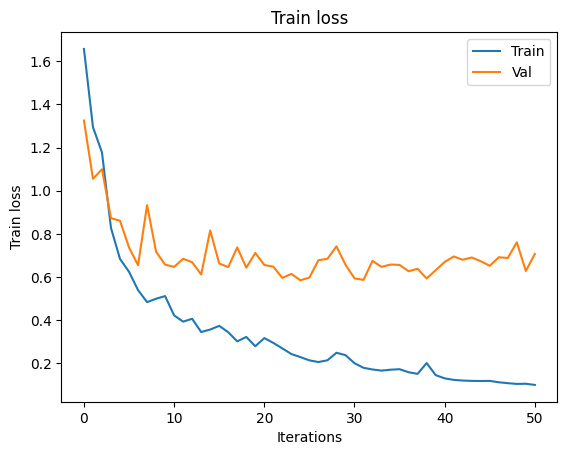

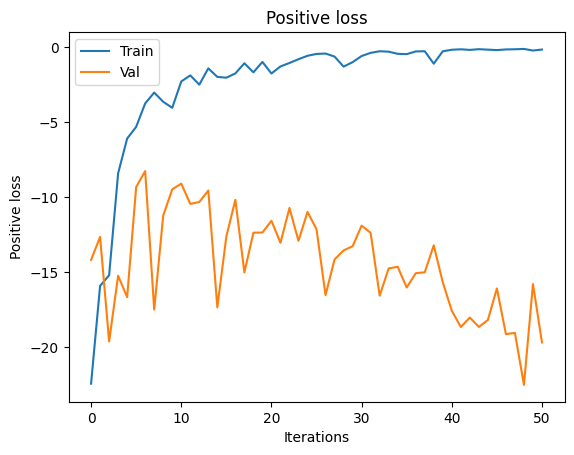

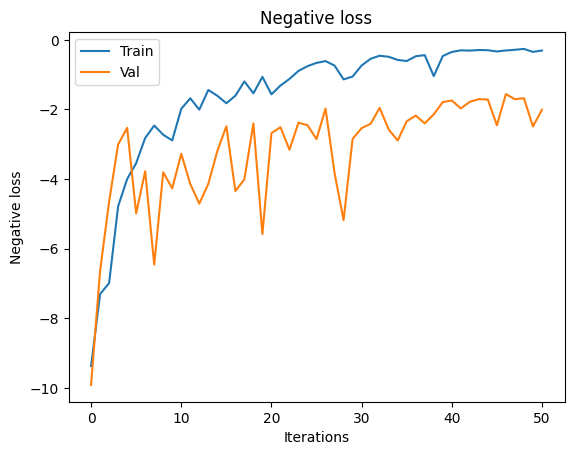

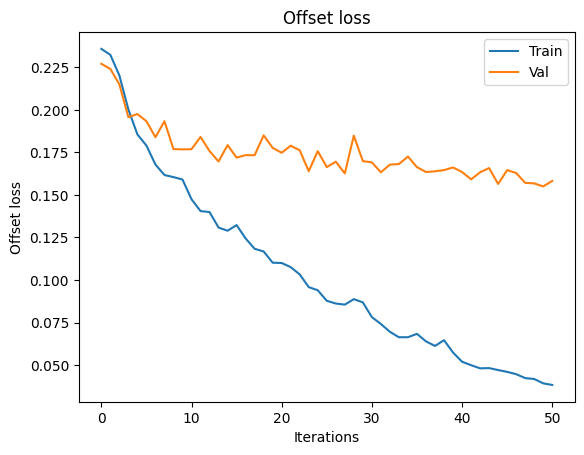

In [24]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

In [ ]:
#modeldone

In [ ]:
#model.load_state_dict(torch.load("hardnet-centernet-oriented-bbox.pth"))
model.eval()

threshold = 0.2

for id in range(40):
    img, hm_gt, offset_gt, regr_gt, angle_gt,mask = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh, angle = model(img.to(device).float().unsqueeze(0))

    
    hm = hm.cpu().numpy().squeeze(0)#.squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    angle = angle.cpu().numpy().squeeze(0)
    
    print(hm.shape)

    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(dataset_folder, img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    plt.imshow(hm[0])
    plt.show()
    
    plt.imshow(hm[1])
    plt.show()
    hm_4corner = select(hm[1], threshold)
    hm = select(hm[0], threshold)
    
    
    plt.imshow(hm>threshold)
    plt.title(f"Heatmap > {threshold}")
    plt.show()

    plt.imshow(hm_4corner>threshold)
    plt.title(f"Heatmap 4 corner> {threshold}")
    plt.show()
    
    plt.imshow(wh[0])
    plt.title("Width heatmap (x)")
    plt.show()
    
    sample = showbox(img, hm, offset, wh, angle, threshold)
    plt.imshow(offset[0])
    plt.title("Offset heatmap (x)")
    plt.show()
    print(sample.shape)
    
    # show gt
    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()

In [10]:
def resize_and_pad(image, target_size=(512, 512)):
    original_height, original_width = image.shape[:2]
    target_width, target_height = target_size

    # Calculate the scaling factor
    scale = min(target_width / original_width, target_height / original_height)
    
    # Calculate new dimensions
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))
    
    # Pad the image to the target size
    delta_w = target_width - new_width
    delta_h = target_height - new_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    return padded_image, scale, left, top

In [ ]:
fps = False
half = False

model.load_state_dict(torch.load("4corner_hardnet_barcode_angle_great_results.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if fps:
    from time import time

if half:
    model.half()
    
cap = cv2.VideoCapture(0)
threshold = 0.2
while 1:
    ret,frame = cap.read()
    #image = cv2.resize(frame,(input_width,input_height))
    image = resize_and_pad(frame,target_size=(input_width,input_height))[0]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = image.copy()
    img = Normalize()(img)
    img = img.transpose([2,0,1])
    img = torch.from_numpy(img)
    if fps: f1 = time()
    if half:
        tensor = img.to(device).half().unsqueeze(0)
    else:
        tensor = img.to(device).float().unsqueeze(0)
    with torch.no_grad():
        hm, offset, wh, angle = model(tensor)
    if fps: f2 = time(); print("Fps:",1/(f2-f1))
    hm = hm.cpu().numpy().squeeze(0)#.squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    angle = angle.cpu().numpy().squeeze(0)
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = select(hm[0], threshold)
    sample = showbox(image, hm, offset, wh, angle, threshold)
    cv2.imshow("output",sample)
    ch = cv2.waitKey(1)
    if ch == ord("q"):
        cv2.destroyAllWindows()
        break
cap.release()

In [ ]:
from glob import glob

test_folder = glob("C:/Users/John/Desktop/rotated_barcode/roboflow_barcode/test/images/*.jpg")
threshold = 0.2
for i in test_folder:
    image = cv2.imread(i)
    #image = cv2.resize(frame,(input_width,input_height))
    image = resize_and_pad(image,target_size=(input_width,input_height))[0]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = image.copy()
    img = Normalize()(img)
    cv2.imshow("normalized",img)
    img = img.transpose([2,0,1])
    img = torch.from_numpy(img)
    if half:
        tensor = img.to(device).half().unsqueeze(0)
    else:
        tensor = img.to(device).float().unsqueeze(0)
        
    with torch.no_grad():
        hm, offset, wh, angle = model(tensor)
    hm = hm.cpu().numpy().squeeze(0)#.squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    angle = angle.cpu().numpy().squeeze(0)
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = select(hm[0], threshold)
    sample = showbox(image, hm, offset, wh, angle, threshold)
    cv2.imshow("output",sample)
    ch = cv2.waitKey(0)
    if ch == ord("q"):
        cv2.destroyAllWindows()
        break
#cap.release()

In [30]:
#torch.save(model.state_dict(), "4corner_hardnet_barcode_angle_great_results.pth") 

In [13]:
def pred4corner(hm,thresh=0.99):
    threshold = 0.2  # Adjust this threshold as needed
    _, thresholded_heatmap = cv2.threshold(hm, threshold, 1, cv2.THRESH_BINARY)
    
    # Find contours (connected components) in the thresholded heatmap
    contours, _ = cv2.findContours(thresholded_heatmap.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    keypoints = []
    for cnt in contours:
        # 2. Refine peak location (using contour center)
        try:
            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            keypoints.append((cx, cy))
        except:
            continue
    return keypoints

In [51]:
from glob import glob

test_folder = glob("C:/Users/John/Desktop/rotated_barcode/roboflow_barcode/test/images/*.jpg")[3:]
threshold = 0.2
for i in test_folder:
    image = cv2.imread(i)
    #image = cv2.resize(frame,(input_width,input_height))
    image = resize_and_pad(image,target_size=(input_width,input_height))[0]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = image.copy()
    img = Normalize()(img)
    img = img.transpose([2,0,1])
    img = torch.from_numpy(img)
    if half:
        tensor = img.to(device).half().unsqueeze(0)
    else:
        tensor = img.to(device).float().unsqueeze(0)
        
    with torch.no_grad():
        hm, offset, wh, angle = model(tensor)
    hm = hm.cpu().numpy().squeeze(0)#.squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    angle = angle.cpu().numpy().squeeze(0)
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()[1]
    #hm = select(hm[1], threshold)
    #sample = showbox(image, hm, offset, wh, angle, threshold)
    hm = cv2.resize(hm,(image.shape[1],image.shape[0]))
    _, thresholded_heatmap = cv2.threshold(hm, threshold, 1, cv2.THRESH_BINARY)
    cv2.imshow("thresh",thresholded_heatmap)
    corners = pred4corner(hm,0.2)
    for kp in corners:
        cv2.circle(image, kp, 5, (0, 0, 255), -1)
    cv2.imshow("output",image)
    cv2.imshow("4corner",cv2.resize(hm,(image.shape[1],image.shape[0])))
    ch = cv2.waitKey(0)
    if ch == ord("q"):
        cv2.destroyAllWindows()
        break
#cap.release()

In [ ]:
from glob import glob

cap = cv2.VideoCapture(0)
threshold = 0.2
while 1:
    ret,image = cap.read()
    #image = cv2.resize(frame,(input_width,input_height))
    image = resize_and_pad(image,target_size=(input_width,input_height))[0]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = image.copy()
    img = Normalize()(img)
    img = img.transpose([2,0,1])
    img = torch.from_numpy(img)
    if half:
        tensor = img.to(device).half().unsqueeze(0)
    else:
        tensor = img.to(device).float().unsqueeze(0)
        
    with torch.no_grad():
        hm, offset, wh, angle = model(tensor)
    hm = hm.cpu().numpy().squeeze(0)#.squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    angle = angle.cpu().numpy().squeeze(0)
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()[1]
    #hm = select(hm[1], threshold)
    #sample = showbox(image, hm, offset, wh, angle, threshold)
    hm = cv2.resize(hm,(image.shape[1],image.shape[0]))
    _, thresholded_heatmap = cv2.threshold(hm, threshold, 1, cv2.THRESH_BINARY)
    cv2.imshow("thresh",thresholded_heatmap)
    corners = pred4corner(hm,0.2)
    for kp in corners:
        cv2.circle(image, kp, 5, (0, 0, 255), -1)
    cv2.imshow("output",image)
    cv2.imshow("4corner",cv2.resize(hm,(image.shape[1],image.shape[0])))
    ch = cv2.waitKey(1)
    if ch == ord("q"):
        cv2.destroyAllWindows()
        break
#cap.release()

rand_torch = torch.rand((1,3,512,512)).cuda()
traced = torch.jit.trace(model,rand_torch)
torch.jit.save(traced, "hardnet_angle_4c_centernet_jit.pth")

## Inference

In [ ]:
#convert the entire code to c++, implement each function
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math
from sklearn.model_selection import train_test_split
import schedulefree
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
#from torchinfo import summary
import torch.optim as optim
from functools import partial
assert torch.cuda.is_available()

# Not always necessary depending on your hardware/GPU
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 512
input_height = 512

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 4
workers = 8
# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 8



def load_model(model, model_path, optimizer=None, resume=False, 
               lr=None, lr_step=None):
  start_epoch = 0
  checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
  print('loaded {}, epoch {}'.format(model_path, checkpoint['epoch']))
  state_dict_ = checkpoint['state_dict']
  state_dict = {}
  
  # convert data_parallal to model
  for k in state_dict_:
    if k.startswith('module') and not k.startswith('module_list'):
      state_dict[k[7:]] = state_dict_[k]
    else:
      state_dict[k] = state_dict_[k]
  model_state_dict = model.state_dict()

  # check loaded parameters and created model parameters
  msg = 'If you see this, your model does not fully load the ' + \
        'pre-trained weight. Please make sure ' + \
        'you have correctly specified --arch xxx ' + \
        'or set the correct --num_classes for your own dataset.'
  for k in state_dict:
    if k in model_state_dict:
      if state_dict[k].shape != model_state_dict[k].shape:
        print('Skip loading parameter {}, required shape{}, '\
              'loaded shape{}. {}'.format(
          k, model_state_dict[k].shape, state_dict[k].shape, msg))
        state_dict[k] = model_state_dict[k]
    else:
      print('Drop parameter {}.'.format(k) + msg)
  for k in model_state_dict:
    if not (k in state_dict):
      print('No param {}.'.format(k) + msg)
      state_dict[k] = model_state_dict[k]
  model.load_state_dict(state_dict, strict=False)

  # resume optimizer parameters
  if optimizer is not None and resume:
    if 'optimizer' in checkpoint:
      optimizer.load_state_dict(checkpoint['optimizer'])
      start_epoch = checkpoint['epoch']
      start_lr = lr
      for step in lr_step:
        if start_epoch >= step:
          start_lr *= 0.1
      for param_group in optimizer.param_groups:
        param_group['lr'] = start_lr
      print('Resumed optimizer with start lr', start_lr)
    else:
      print('No optimizer parameters in checkpoint.')
  if optimizer is not None:
    return model, optimizer, start_epoch
  else:
    return model

from hardnet import get_pose_net
model = get_pose_net(85,{"hm":2,"offset":2,"wh":2,"angle":2})
model = load_model(model,"centernet_hardnet85_coco.pth")


fps = False
half = False

model.load_state_dict(torch.load("4corner_hardnet_barcode_angle_great_results.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [48]:

# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image


def pred2box(hm, offset, regr, cos_sin_hm, thresh=0.99):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b, pred_angle) in zip(pred_center, pred_r, pred_angles):
        print(b)
        print(pred_center)
        offset_xy = offset[:, center[0], center[1]]
        print(offset_xy)
        angle = np.arctan2(pred_angle[1], pred_angle[0])
        print(angle)
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE, angle])
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    print("Boxes:",boxes)
    return np.asarray(boxes), scores


def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm

def resize_and_pad(image, target_size=(512, 512)):
    original_height, original_width = image.shape[:2]
    target_width, target_height = target_size

    # Calculate the scaling factor
    scale = min(target_width / original_width, target_height / original_height)
    
    # Calculate new dimensions
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))
    
    # Pad the image to the target size
    delta_w = target_width - new_width
    delta_h = target_height - new_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    return padded_image, scale, left, top


def pred4corner(hm,thresh=0.99):
    threshold = 0.2  # Adjust this threshold as needed
    _, thresholded_heatmap = cv2.threshold(hm, threshold, 1, cv2.THRESH_BINARY)
    
    # Find contours (connected components) in the thresholded heatmap
    contours, _ = cv2.findContours(thresholded_heatmap.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    keypoints = []
    for cnt in contours:
        # 2. Refine peak location (using contour center)
        try:
            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            keypoints.append((cx, cy))
        except:
            continue
    return keypoints



# functions for plotting results
def showbox(img, hm, offset, regr, cos_sin_hm, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, cos_sin_hm, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])]
        cos_angle = np.cos(box[4])
        sin_angle = np.sin(box[4])
        rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        
        bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        thickness = 3
        cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
                      (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
                      (0, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
                      (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
                      (220, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
                      (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
                      (220, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
                      (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
                      (220, 220, 0), thickness)
    return sample


print("Done")
#cap.release()

Done


In [ ]:
from glob import glob

test_folder = glob("C:/Users/John/Desktop/rotated_barcode/roboflow_barcode/test/images/*.jpg")
threshold = 0.2
for i in test_folder:
    image = cv2.imread(i)
    #image = cv2.resize(frame,(input_width,input_height))
    image = resize_and_pad(image,target_size=(input_width,input_height))[0]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = image.copy()
    img = Normalize()(img)
    cv2.imshow("normalized",img)
    img = img.transpose([2,0,1])
    img = torch.from_numpy(img)
    if half:
        tensor = img.to(device).half().unsqueeze(0)
    else:
        tensor = img.to(device).float().unsqueeze(0)
        
    with torch.no_grad():
        hm, offset, wh, angle = model(tensor)
    hm = hm.cpu().numpy().squeeze(0)#.squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    angle = angle.cpu().numpy().squeeze(0)
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = select(hm[0], threshold)
    sample = showbox(image, hm, offset, wh, angle, threshold)
    print(offset.mean())
    print(angle.mean())
    print(wh.mean())
    cv2.imshow("output",sample)
    ch = cv2.waitKey(0)
    if ch == ord("q"):
        cv2.destroyAllWindows()
        break